In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from scipy.stats import norm
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, ConvTranspose2d

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

# Utils

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [3]:
# Shows the first batch of images
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [4]:
def plot_list(data, title):
    plt.plot(data)
    plt.title(title)
    plt.xlabel('steps')
    plt.ylabel(title)
    
    plt.show()

In [5]:
def plot_noise(x_0, alpha_bar, title):
    mean = np.sqrt(alpha_bar)*x_0
    std = 1-alpha_bar
    
    # Plot between -10 and 10 with .001 steps.
    x_axis = np.arange(-5, 5, 0.001)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.axvline(x = x_0, color = 'r', label = 'x_0', linestyle=':')
    plt.title(title)
    plt.show()

In [6]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            steps = [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]
            show_images(ddpm(imgs.to(device), steps), f"DDPM Noisy images {int(percent * 100)}%")
        break

# Hyperparams

In [7]:
batch_size = 64
n_epochs = 2
n_steps = 1000
lr = 0.001
store_path = "ddpm_mnist.pt"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [8]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform) + ds_fn("./datasets", download=True, train=False, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 112121332.34it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108156869.49it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27335214.98it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8655396.99it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



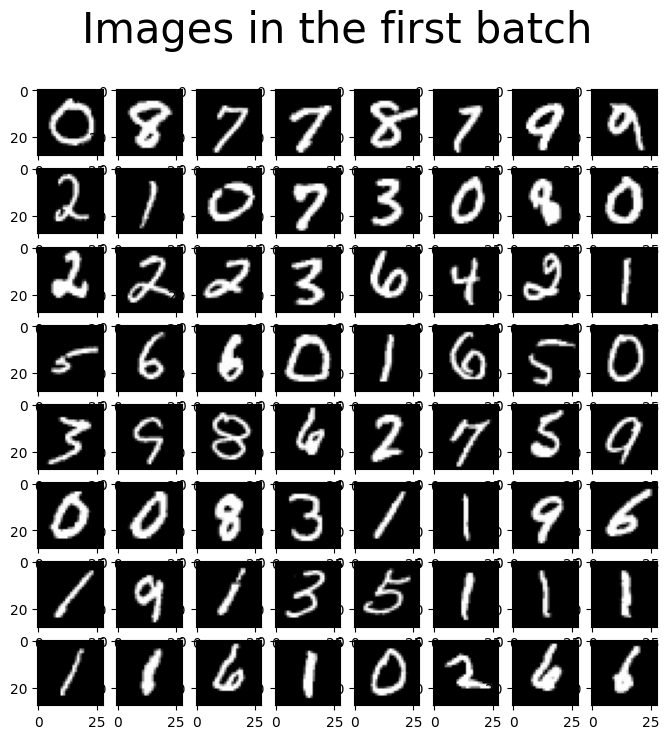

In [9]:
show_first_batch(loader)

# DDPM Model

## Need to have

$x_{t+1} = \sqrt{\bar{\alpha_{t+1}}}x_{t} + \epsilon\sqrt{1-\bar{\alpha_{t+1}}}$

*where* 

$\epsilon \sim N(0, I)$  
$\bar{\alpha_{t}} = \prod_{s=1}^{t}\alpha_{s}$  
$\alpha_{t} = 1 - \beta_{t}$  

In [10]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=1000, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t].to(device)

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Let's take a closer look

In [11]:
dummy = MyDDPM(torch.rand(1,2), device=device)

As you remember, beta is a measure of the noise which is added to the initial value. In our case we add more and more noise on the each step

As we can see, alpha-bar is decreasing across the steps. At the first step we have a pure x_0. On the last step we have a pure noise.

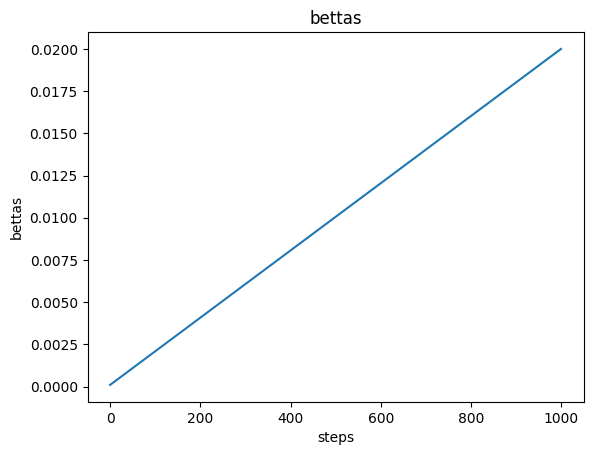

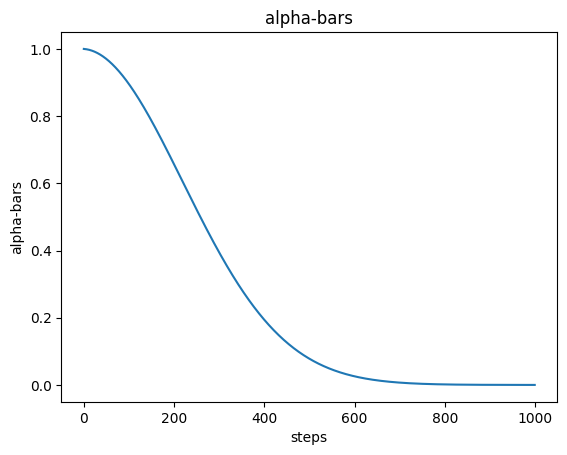

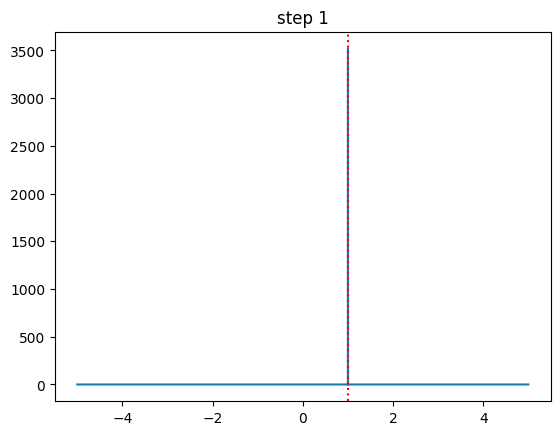

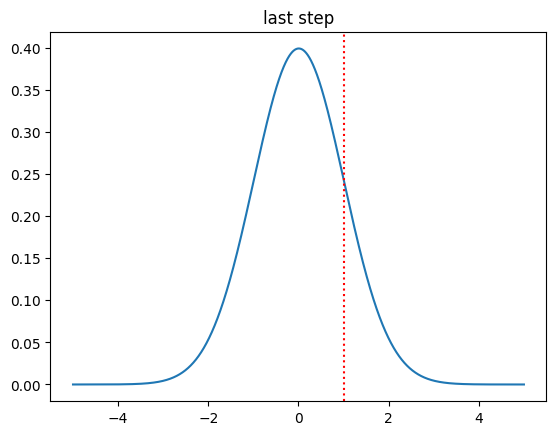

In [12]:
plot_list(dummy.betas.detach().cpu(), 'bettas')
plot_list(dummy.alpha_bars.detach().cpu(), 'alpha-bars')
plot_noise(1, dummy.alpha_bars[0].detach().cpu(), 'step 1')
plot_noise(1, dummy.alpha_bars[-1].detach().cpu(), 'last step')

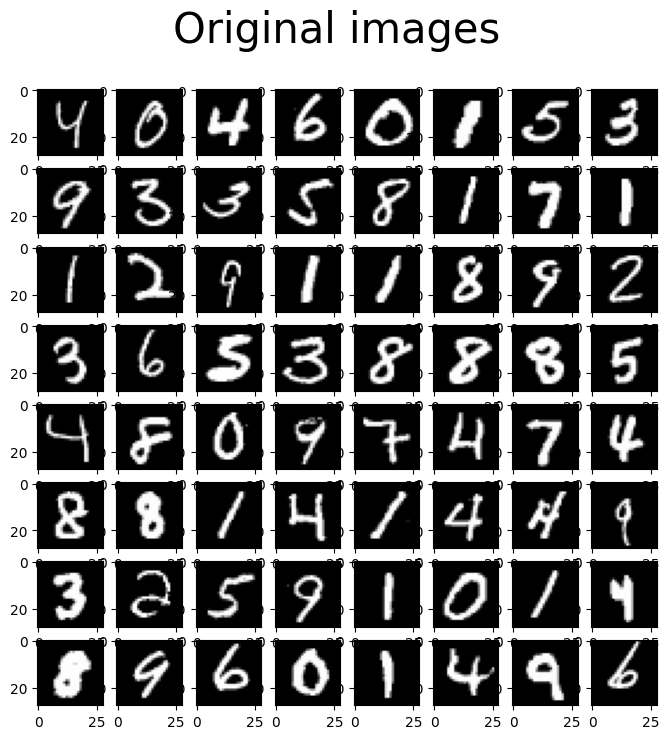

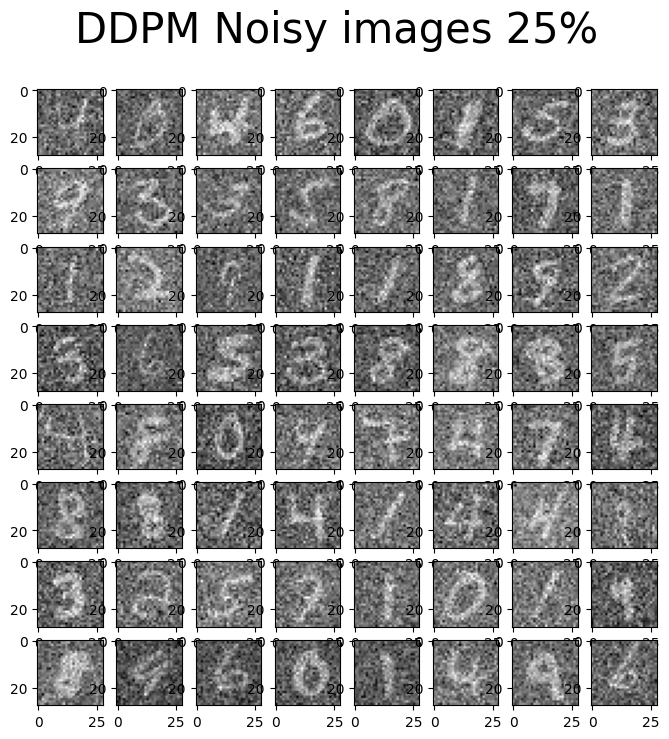

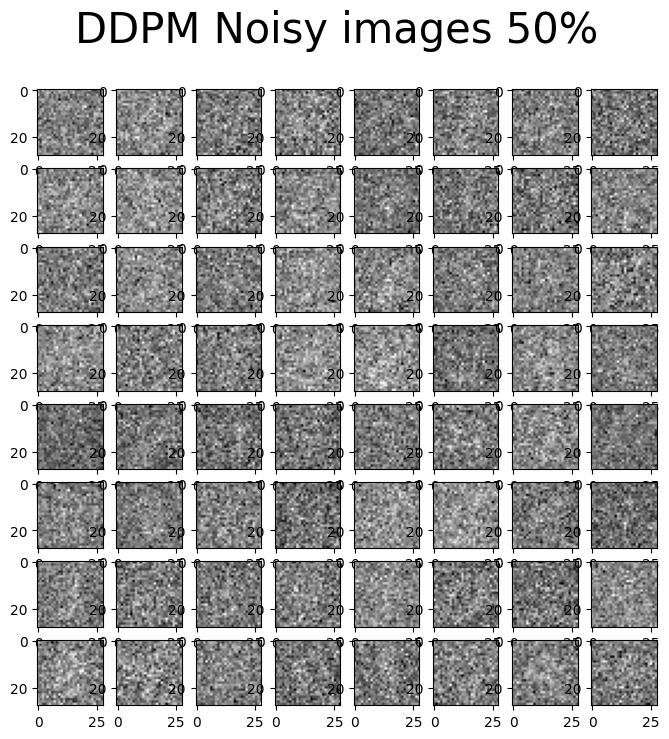

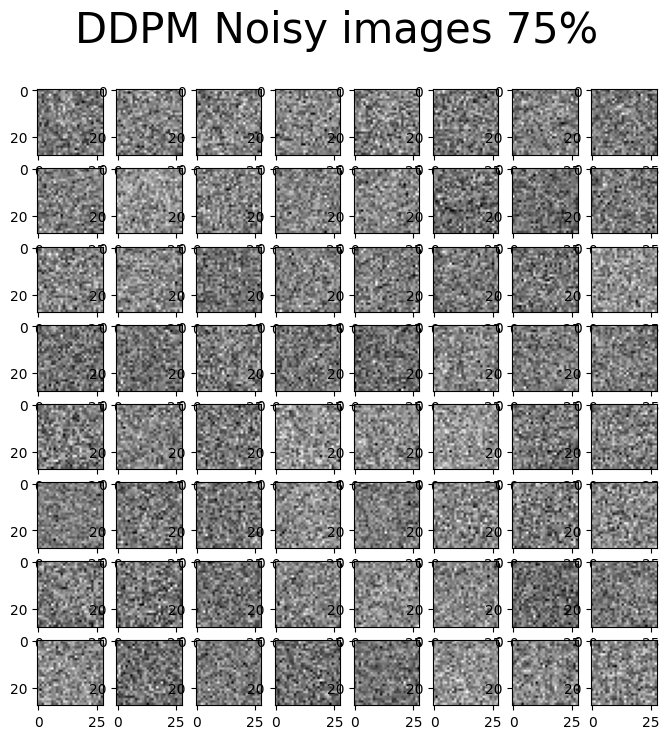

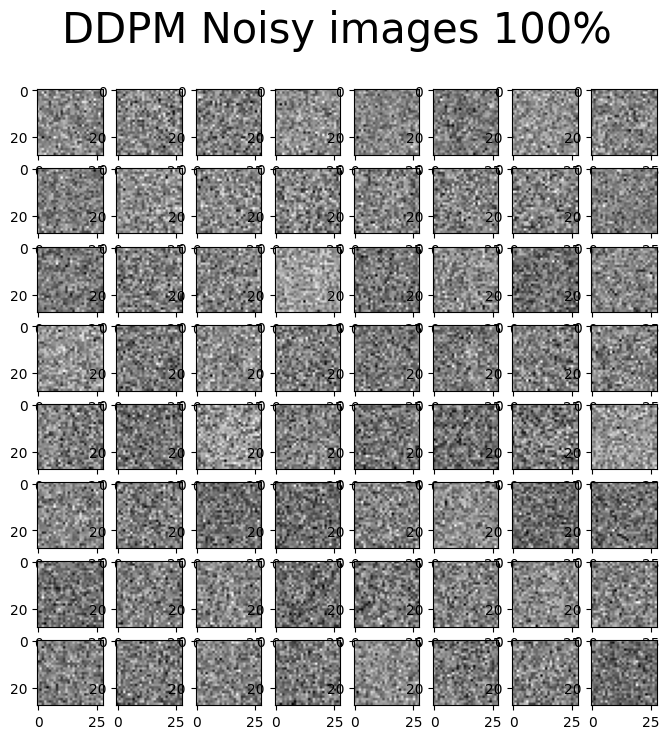

In [13]:
show_forward(dummy, loader, device)

# Denoising Network 

As you probably remember, we would need to minimize the following functional on each step:


$L_{simple} = \mathop{\mathbb{E}}\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert$

Where $\epsilon_{\theta}(x_t, t)$ should be modeled by the network. It means that our network should take $x_t$ and $t$ as inputs, and return noise with the same shape as $x_t$

## Question for you!

How $t$ argument should be represented to be used in the neural network?

Can we do that as it's done in transformers? Let's try!

# sin-cos-embedding

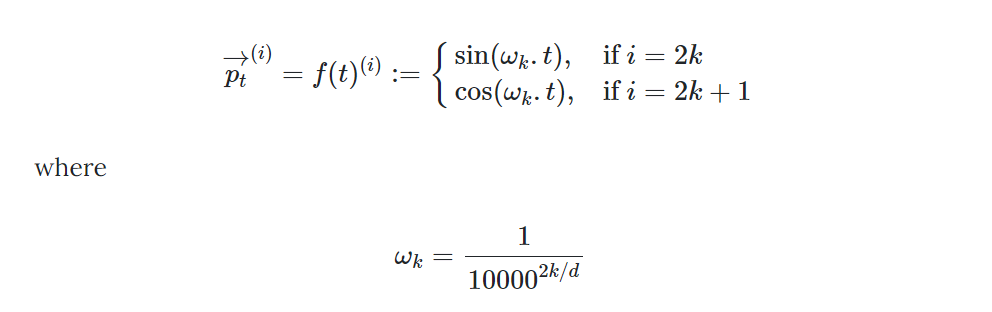

In [14]:
# time emdedding

def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [15]:
class TimeStepNet(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(TimeStepNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )
        
    def forward(self, x):
        return self.net(x)

In [16]:
class NetworkBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(NetworkBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

    
class UNetNaMinimalkax(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNetNaMinimalkax, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = TimeStepNet(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            NetworkBlock((1, 28, 28), 1, 10),
            NetworkBlock((10, 28, 28), 10, 10),
            NetworkBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = TimeStepNet(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            NetworkBlock((10, 14, 14), 10, 20),
            NetworkBlock((20, 14, 14), 20, 20),
            NetworkBlock((20, 14, 14), 20, 20)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(20, 20, 4, 2, 1),
            nn.SiLU(),
            nn.Conv2d(20, 20, 3, 1, 1)
        )

        self.te3 = TimeStepNet(time_emb_dim, 30)
        self.b3 = nn.Sequential(
            NetworkBlock((30, 28, 28), 30, 20),
            NetworkBlock((20, 28, 28), 20, 20),
            NetworkBlock((20, 28, 28), 20, 20)
        )

        self.b4 = nn.Sequential(
            NetworkBlock((20, 28, 28), 20, 20),
            NetworkBlock((20, 28, 28), 20, 10),
            NetworkBlock((10, 28, 28), 10, 10)
        )

        self.conv_out = nn.Conv2d(10, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.up1(out2) # (N, 20, 28, 28)
        out4 = torch.cat((out1, out3), dim = 1) + self.te3(t).reshape(n, -1, 1, 1)
        out5 = self.b3(out4)
        out6 = self.b4(out5)
        return self.conv_out(out6)

# Training loop

In [17]:
model = MyDDPM(UNetNaMinimalkax(n_steps=n_steps, time_emb_dim=100), n_steps=n_steps, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def training_loop(ddpm, loader, n_epochs, optim, device):    
    mse = nn.MSELoss()
    loss_epoch = []
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            epsilon = torch.randn_like(x0).to(device)            
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, epsilon)

            # Getting model estimation of noise based on the images and the time-step
            epsilon_theta = ddpm.backward(noisy_imgs, t)

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(epsilon_theta, epsilon)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            loss_epoch.append(loss.detach().cpu().numpy())
            
            if step%20 == 0:
                clear_output(wait=True)
                plt.plot(loss_epoch)  # Simple plot
                plt.title(f'Iteration {step}')
                display(plt.gcf())
                

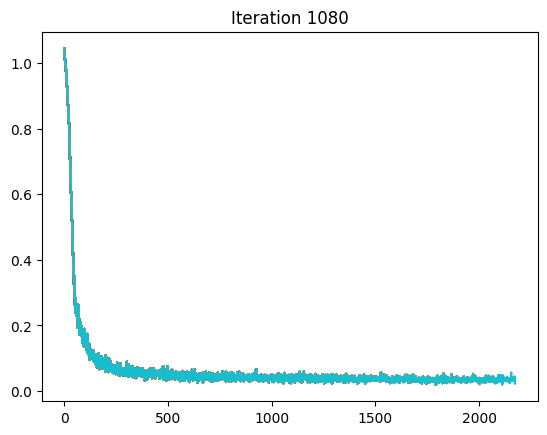

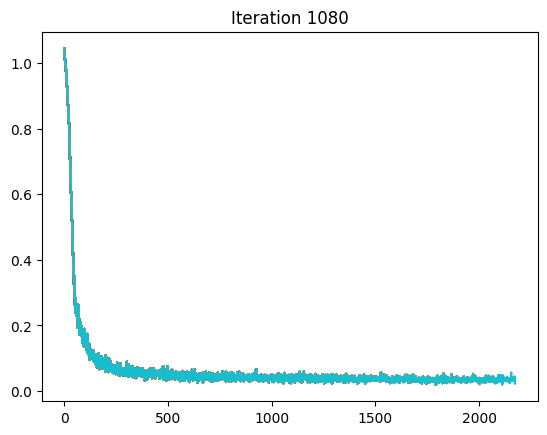

In [19]:
training_loop(model, loader, n_epochs, optimizer, device)

# Let's generate something

## Sampling algorithm


$x_{T} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

**for t in T,..,1 do**

$\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if t > 0 else $\mathbf{z} = 0$

$x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}}(x_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}}\epsilon_{\theta}) + \sqrt{1-\alpha_{t}}\mathbf{z}$

**end for** 

In [20]:
def generate_new_images(ddpm, n_samples=16, frames_per_gif=100, image_shape=(1, 28, 28)):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    with torch.no_grad():
        # Starting from random noise
        x = torch.randn(n_samples, *image_shape).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()            
            epsilon_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * epsilon_theta)

            if t > 0:
                z = torch.randn(n_samples, *image_shape).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z
    return x

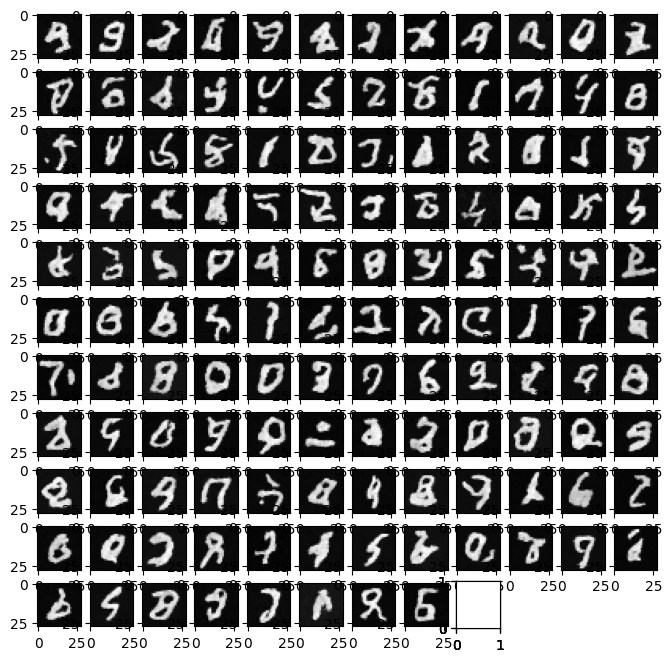

In [21]:
generated = generate_new_images(model, n_samples=128)
show_images(generated)

# Conditional sampling

first of all we need to train noisy classifier

In [22]:
class NoisyClassifierNetwork(nn.Module):
    def __init__(self, base_net):
        super(NoisyClassifierNetwork, self).__init__()
        self.unet = base_net
        self.activation = nn.SiLU()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x, t):
        out = self.unet(x, t)
        out = self.activation(x)
        out = out.flatten(start_dim=1)
        out = self.linear(out)
        return out


In [23]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def classifier_training_loop(ddpm, classifier, loader, n_epochs, optim, device):    
    cross_entropy = CrossEntropyLoss()
    loss_epoch = []
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            correct_y = batch[1].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            epsilon = torch.randn_like(x0).to(device)            
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, epsilon)

            # Getting model estimation of noise based on the images and the time-step
            logits = classifier(noisy_imgs, t)

            # Optimizing the cross-entropy between the noise plugged and the predicted noise
            loss = cross_entropy(logits, correct_y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            loss_epoch.append(loss.detach().cpu().numpy())
            
            if step%20 == 0:
                clear_output(wait=True)
                plt.plot(loss_epoch)  # Simple plot
                plt.title(f'Iteration {step}')
                display(plt.gcf())
                

In [24]:
classifier = NoisyClassifierNetwork(UNetNaMinimalkax(n_steps=n_steps, time_emb_dim=100)).to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

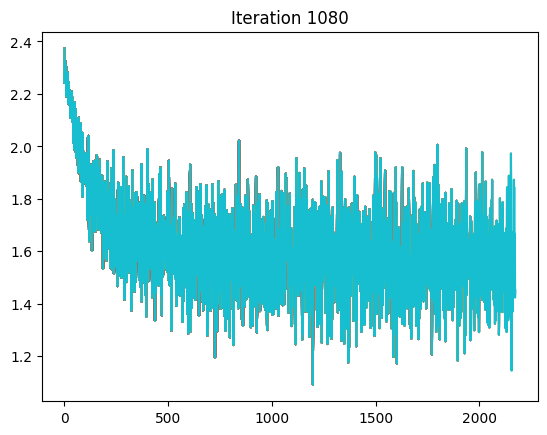

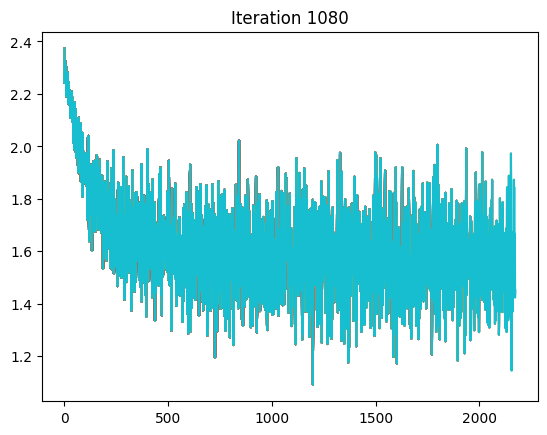

In [25]:
classifier_training_loop(model, classifier, loader, n_epochs, classifier_optimizer, device)

# Conditional generation

In [26]:
def generate_conditional(ddpm, classifier, digit, gamma, n_samples=16, image_shape=(1, 28, 28)):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    with torch.no_grad():
        # Starting from random noise
        x = torch.randn(n_samples, *image_shape).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            
            # calculate epsilon theta
            epsilon_theta = ddpm.backward(x, time_tensor)
            
            # calculate likelihood
            with torch.enable_grad():
                x.requires_grad = True
                logits = classifier(x, time_tensor)
                log_probs = nn.LogSoftmax(dim=-1)(logits)
                log_probs_digit = log_probs[:, digit]
                log_probs_grad = torch.autograd.grad([element for element in log_probs_digit], x)[0]
                if torch.any(log_probs_grad.isnan()).item():
                    return logits, log_probs, x
            
            # calcualte epsilon_theta_phi            
            epsilon_theta_phi = epsilon_theta - (1 - alpha_t_bar).sqrt()*gamma*log_probs_grad
            

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * epsilon_theta_phi)

            if t > 0:
                z = torch.randn(n_samples, *image_shape).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z
    return x

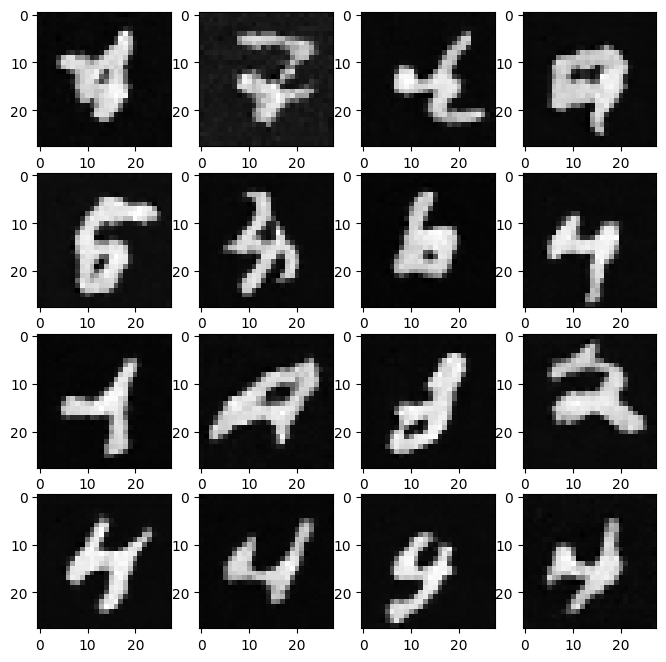

In [27]:
generated_conditional = generate_conditional(model, classifier, 4, 10)
show_images(generated_conditional)